## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
import keras
import itertools
# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import Dense, BatchNormalization, Activation

# norm_type = {'input' / 'before_act' / 'after_act' / 'no'(N/A) }
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128], norm_type=''):
    input_layer = keras.layers.Input(input_shape)

    x = input_layer
    if norm_type == 'input':
        x = BatchNormalization()(x)
        
    for i, n_units in enumerate(num_neurons):
        if norm_type == 'before_act':
            x = Dense(units=n_units, 
                        name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
        elif norm_type == 'after_act':
            x = Dense(units=n_units, 
                        activation="relu", 
                        name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=n_units, 
                        activation="relu", 
                        name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
MOMENTUM = 0.95

norm_type_list = ['no', 'before_act', 'after_act', 'input']
#batch_size_list = [2, 16, 32, 128, 256]
batch_size_list = [128, 256, 512, 1024]

In [7]:
KEY_PREFIX_BATCH_SIZE = 'batch'
KEY_PREFIX_NORM_TYPE = 'norm'

results = {}

for batch_size in batch_size_list:
    for norm_type in norm_type_list:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        
        model = build_mlp(input_shape=x_train.shape[1:], norm_type=norm_type)
        print(model.summary())
 
        print()
        print('-'*60)
        print(f"Experiment with batch_size={batch_size}  norm_type={norm_type}")
        print()
        
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=batch_size, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = f"{KEY_PREFIX_NORM_TYPE}:{norm_type}-{KEY_PREFIX_BATCH_SIZE}:{batch_size}"
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________
None

------------------------------------------------------

50000/50000 [==============================] - 13s 254us/step - loss: 0.6953 - acc: 0.7538 - val_loss: 1.5314 - val_acc: 0.5323
Epoch 48/50
50000/50000 [==============================] - 12s 245us/step - loss: 0.6746 - acc: 0.7641 - val_loss: 1.5173 - val_acc: 0.5357
Epoch 49/50
50000/50000 [==============================] - 12s 246us/step - loss: 0.6642 - acc: 0.7661 - val_loss: 1.5387 - val_acc: 0.5339
Epoch 50/50
50000/50000 [==============================] - 12s 247us/step - loss: 0.6444 - acc: 0.7725 - val_loss: 1.5738 - val_acc: 0.5335
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2

50000/50000 [==============================] - 14s 276us/step - loss: 0.0747 - acc: 0.9809 - val_loss: 2.8758 - val_acc: 0.4649
Epoch 42/50
50000/50000 [==============================] - 14s 276us/step - loss: 0.0630 - acc: 0.9853 - val_loss: 2.7894 - val_acc: 0.4846
Epoch 43/50
50000/50000 [==============================] - 14s 277us/step - loss: 0.0639 - acc: 0.9837 - val_loss: 2.8636 - val_acc: 0.4697
Epoch 44/50
50000/50000 [==============================] - 14s 276us/step - loss: 0.0640 - acc: 0.9837 - val_loss: 2.9790 - val_acc: 0.4762
Epoch 45/50
50000/50000 [==============================] - 14s 276us/step - loss: 0.0617 - acc: 0.9843 - val_loss: 3.0657 - val_acc: 0.4596
Epoch 46/50
50000/50000 [==============================] - 14s 277us/step - loss: 0.0498 - acc: 0.9887 - val_loss: 2.9732 - val_acc: 0.4728
Epoch 47/50
50000/50000 [==============================] - 14s 278us/step - loss: 0.0512 - acc: 0.9879 - val_loss: 2.9245 - val_acc: 0.4811
Epoch 48/50
50000/50000 [=======

50000/50000 [==============================] - 14s 278us/step - loss: 0.3977 - acc: 0.8622 - val_loss: 2.1792 - val_acc: 0.4573
Epoch 39/50
50000/50000 [==============================] - 14s 278us/step - loss: 0.3845 - acc: 0.8681 - val_loss: 2.2226 - val_acc: 0.4664
Epoch 40/50
50000/50000 [==============================] - 14s 278us/step - loss: 0.3702 - acc: 0.8746 - val_loss: 2.2655 - val_acc: 0.4626
Epoch 41/50
50000/50000 [==============================] - 14s 279us/step - loss: 0.3670 - acc: 0.8720 - val_loss: 2.3351 - val_acc: 0.4541
Epoch 42/50
50000/50000 [==============================] - 14s 279us/step - loss: 0.3495 - acc: 0.8787 - val_loss: 2.5055 - val_acc: 0.4427
Epoch 43/50
50000/50000 [==============================] - 14s 280us/step - loss: 0.3365 - acc: 0.8855 - val_loss: 2.2037 - val_acc: 0.4775
Epoch 44/50
50000/50000 [==============================] - 14s 278us/step - loss: 0.3231 - acc: 0.8880 - val_loss: 2.3379 - val_acc: 0.4615
Epoch 45/50
50000/50000 [=======

50000/50000 [==============================] - 14s 288us/step - loss: 0.1271 - acc: 0.9596 - val_loss: 2.6594 - val_acc: 0.5179
Epoch 38/50
50000/50000 [==============================] - 14s 288us/step - loss: 0.1247 - acc: 0.9597 - val_loss: 2.6537 - val_acc: 0.5211
Epoch 39/50
50000/50000 [==============================] - 15s 291us/step - loss: 0.1104 - acc: 0.9660 - val_loss: 2.6941 - val_acc: 0.5300
Epoch 40/50
50000/50000 [==============================] - 14s 289us/step - loss: 0.1048 - acc: 0.9662 - val_loss: 2.6946 - val_acc: 0.5224
Epoch 41/50
50000/50000 [==============================] - 14s 289us/step - loss: 0.0934 - acc: 0.9719 - val_loss: 2.7763 - val_acc: 0.5265
Epoch 42/50
50000/50000 [==============================] - 14s 287us/step - loss: 0.0920 - acc: 0.9712 - val_loss: 2.8838 - val_acc: 0.5265
Epoch 43/50
50000/50000 [==============================] - 14s 287us/step - loss: 0.0964 - acc: 0.9692 - val_loss: 2.8510 - val_acc: 0.5256
Epoch 44/50
50000/50000 [=======

50000/50000 [==============================] - 10s 200us/step - loss: 1.0210 - acc: 0.6408 - val_loss: 1.3633 - val_acc: 0.5224
Epoch 38/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.0068 - acc: 0.6455 - val_loss: 1.3410 - val_acc: 0.5258
Epoch 39/50
50000/50000 [==============================] - 10s 200us/step - loss: 0.9989 - acc: 0.6485 - val_loss: 1.3426 - val_acc: 0.5344
Epoch 40/50
50000/50000 [==============================] - 10s 200us/step - loss: 0.9905 - acc: 0.6508 - val_loss: 1.3521 - val_acc: 0.5293
Epoch 41/50
50000/50000 [==============================] - 10s 200us/step - loss: 0.9740 - acc: 0.6581 - val_loss: 1.3863 - val_acc: 0.5279 - lo
Epoch 42/50
50000/50000 [==============================] - 10s 198us/step - loss: 0.9606 - acc: 0.6638 - val_loss: 1.4034 - val_acc: 0.5206
Epoch 43/50
50000/50000 [==============================] - 10s 199us/step - loss: 0.9482 - acc: 0.6674 - val_loss: 1.4831 - val_acc: 0.5020
Epoch 44/50
50000/50000 [==

50000/50000 [==============================] - 11s 229us/step - loss: 0.1839 - acc: 0.9590 - val_loss: 2.2184 - val_acc: 0.4712
Epoch 32/50
50000/50000 [==============================] - 12s 231us/step - loss: 0.1646 - acc: 0.9663 - val_loss: 2.2660 - val_acc: 0.4622
Epoch 33/50
50000/50000 [==============================] - 11s 229us/step - loss: 0.1490 - acc: 0.9699 - val_loss: 2.2011 - val_acc: 0.4762
Epoch 34/50
50000/50000 [==============================] - 11s 229us/step - loss: 0.1347 - acc: 0.9746 - val_loss: 2.3742 - val_acc: 0.4667
Epoch 35/50
50000/50000 [==============================] - 12s 231us/step - loss: 0.1196 - acc: 0.9794 - val_loss: 2.3996 - val_acc: 0.4623
Epoch 36/50
50000/50000 [==============================] - 12s 230us/step - loss: 0.1140 - acc: 0.9796 - val_loss: 2.2636 - val_acc: 0.4849
Epoch 37/50
50000/50000 [==============================] - 12s 230us/step - loss: 0.1002 - acc: 0.9832 - val_loss: 2.3445 - val_acc: 0.4641
Epoch 38/50
50000/50000 [=======

50000/50000 [==============================] - 11s 230us/step - loss: 0.5318 - acc: 0.8251 - val_loss: 1.8464 - val_acc: 0.4724
Epoch 29/50
50000/50000 [==============================] - 12s 231us/step - loss: 0.5042 - acc: 0.8353 - val_loss: 1.8291 - val_acc: 0.4850
Epoch 30/50
50000/50000 [==============================] - 12s 231us/step - loss: 0.4831 - acc: 0.8427 - val_loss: 1.8269 - val_acc: 0.4711
Epoch 31/50
50000/50000 [==============================] - 12s 232us/step - loss: 0.4596 - acc: 0.8518 - val_loss: 1.9059 - val_acc: 0.4653
Epoch 32/50
50000/50000 [==============================] - 12s 230us/step - loss: 0.4371 - acc: 0.8592 - val_loss: 2.0299 - val_acc: 0.4630
Epoch 33/50
50000/50000 [==============================] - 12s 232us/step - loss: 0.4165 - acc: 0.8665 - val_loss: 2.0621 - val_acc: 0.4685
Epoch 34/50
50000/50000 [==============================] - 12s 231us/step - loss: 0.3989 - acc: 0.8738 - val_loss: 1.9940 - val_acc: 0.4700
Epoch 35/50
50000/50000 [=======

50000/50000 [==============================] - 12s 244us/step - loss: 0.4116 - acc: 0.8729 - val_loss: 1.7524 - val_acc: 0.5161
Epoch 28/50
50000/50000 [==============================] - 12s 244us/step - loss: 0.3838 - acc: 0.8829 - val_loss: 1.7909 - val_acc: 0.5126
Epoch 29/50
50000/50000 [==============================] - 12s 245us/step - loss: 0.3571 - acc: 0.8920 - val_loss: 1.8413 - val_acc: 0.5127
Epoch 30/50
50000/50000 [==============================] - 12s 244us/step - loss: 0.3338 - acc: 0.9003 - val_loss: 1.8525 - val_acc: 0.5151
Epoch 31/50
50000/50000 [==============================] - 12s 246us/step - loss: 0.3047 - acc: 0.9090 - val_loss: 1.9138 - val_acc: 0.5165
Epoch 32/50
50000/50000 [==============================] - 12s 246us/step - loss: 0.2843 - acc: 0.9159 - val_loss: 1.9510 - val_acc: 0.5174
Epoch 33/50
50000/50000 [==============================] - 12s 245us/step - loss: 0.2573 - acc: 0.9290 - val_loss: 2.0068 - val_acc: 0.5129
Epoch 34/50
50000/50000 [=======

50000/50000 [==============================] - 9s 172us/step - loss: 1.3418 - acc: 0.5296 - val_loss: 1.4169 - val_acc: 0.5004
Epoch 28/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.3315 - acc: 0.5348 - val_loss: 1.4137 - val_acc: 0.4948
Epoch 29/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.3194 - acc: 0.5396 - val_loss: 1.3993 - val_acc: 0.5052
Epoch 30/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.3103 - acc: 0.5417 - val_loss: 1.3936 - val_acc: 0.5080
Epoch 31/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.2992 - acc: 0.5460 - val_loss: 1.3833 - val_acc: 0.5122
Epoch 32/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.2876 - acc: 0.5493 - val_loss: 1.3805 - val_acc: 0.5132
Epoch 33/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.2780 - acc: 0.5531 - val_loss: 1.3860 - val_acc: 0.5093
Epoch 34/50
50000/50000 [==============

50000/50000 [==============================] - 10s 193us/step - loss: 0.7813 - acc: 0.7512 - val_loss: 1.5065 - val_acc: 0.4880
Epoch 22/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.7475 - acc: 0.7644 - val_loss: 1.4852 - val_acc: 0.4920
Epoch 23/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.7130 - acc: 0.7790 - val_loss: 1.4940 - val_acc: 0.4956
Epoch 24/50
50000/50000 [==============================] - 10s 191us/step - loss: 0.6793 - acc: 0.7909 - val_loss: 1.5339 - val_acc: 0.4921
Epoch 25/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.6451 - acc: 0.8044 - val_loss: 1.5345 - val_acc: 0.4909
Epoch 26/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.6150 - acc: 0.8171 - val_loss: 1.5391 - val_acc: 0.4915
Epoch 27/50
50000/50000 [==============================] - 10s 192us/step - loss: 0.5811 - acc: 0.8318 - val_loss: 1.6027 - val_acc: 0.4828 loss: 0.5630 - acc: 0.8 - ETA: -

50000/50000 [==============================] - 10s 195us/step - loss: 0.9616 - acc: 0.6699 - val_loss: 1.4840 - val_acc: 0.4874
Epoch 18/50
50000/50000 [==============================] - 10s 195us/step - loss: 0.9364 - acc: 0.6798 - val_loss: 1.5181 - val_acc: 0.4773
Epoch 19/50
50000/50000 [==============================] - 10s 195us/step - loss: 0.9070 - acc: 0.6905 - val_loss: 1.4844 - val_acc: 0.4916
Epoch 20/50
50000/50000 [==============================] - 10s 195us/step - loss: 0.8787 - acc: 0.7012 - val_loss: 1.5284 - val_acc: 0.4835
Epoch 21/50
50000/50000 [==============================] - 10s 195us/step - loss: 0.8511 - acc: 0.7149 - val_loss: 1.5057 - val_acc: 0.4887
Epoch 22/50
50000/50000 [==============================] - 10s 196us/step - loss: 0.8243 - acc: 0.7227 - val_loss: 1.5820 - val_acc: 0.4804
Epoch 23/50
50000/50000 [==============================] - 10s 195us/step - loss: 0.7971 - acc: 0.7345 - val_loss: 1.5012 - val_acc: 0.4933cc: 0.73
Epoch 24/50
50000/50000 

50000/50000 [==============================] - 11s 213us/step - loss: 1.1265 - acc: 0.6173 - val_loss: 1.3780 - val_acc: 0.5164
Epoch 16/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.0993 - acc: 0.6284 - val_loss: 1.3778 - val_acc: 0.5170
Epoch 17/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.0725 - acc: 0.6382 - val_loss: 1.3756 - val_acc: 0.5179
Epoch 18/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.0450 - acc: 0.6470 - val_loss: 1.3700 - val_acc: 0.5206
Epoch 19/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.0193 - acc: 0.6552 - val_loss: 1.3695 - val_acc: 0.5233
Epoch 20/50
50000/50000 [==============================] - 11s 213us/step - loss: 0.9923 - acc: 0.6682 - val_loss: 1.3658 - val_acc: 0.5221
Epoch 21/50
50000/50000 [==============================] - 11s 214us/step - loss: 0.9654 - acc: 0.6771 - val_loss: 1.3654 - val_acc: 0.5246
Epoch 22/50
50000/50000 [=======

50000/50000 [==============================] - 8s 159us/step - loss: 1.6365 - acc: 0.4307 - val_loss: 1.6377 - val_acc: 0.4341
Epoch 16/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.6241 - acc: 0.4338 - val_loss: 1.6279 - val_acc: 0.4376
Epoch 17/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.6111 - acc: 0.4398 - val_loss: 1.6159 - val_acc: 0.4403
Epoch 18/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.5996 - acc: 0.4446 - val_loss: 1.6043 - val_acc: 0.4425
Epoch 19/50
50000/50000 [==============================] - 8s 159us/step - loss: 1.5874 - acc: 0.4485 - val_loss: 1.5950 - val_acc: 0.4470
Epoch 20/50
50000/50000 [==============================] - 8s 157us/step - loss: 1.5767 - acc: 0.4512 - val_loss: 1.5855 - val_acc: 0.4516
Epoch 21/50
50000/50000 [==============================] - 8s 158us/step - loss: 1.5657 - acc: 0.4554 - val_loss: 1.5798 - val_acc: 0.4544
Epoch 22/50
50000/50000 [==============

Epoch 10/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.3604 - acc: 0.5302 - val_loss: 1.5126 - val_acc: 0.4656
Epoch 11/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.3322 - acc: 0.5413 - val_loss: 1.4954 - val_acc: 0.4771
Epoch 12/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.3060 - acc: 0.5497 - val_loss: 1.4899 - val_acc: 0.4757
Epoch 13/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.2804 - acc: 0.5601 - val_loss: 1.4716 - val_acc: 0.4811
Epoch 14/50
50000/50000 [==============================] - 9s 172us/step - loss: 1.2556 - acc: 0.5690 - val_loss: 1.4659 - val_acc: 0.4813
Epoch 15/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.2311 - acc: 0.5787 - val_loss: 1.4587 - val_acc: 0.4883
Epoch 16/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.2083 - acc: 0.5883 - val_loss: 1.4500 - val_acc: 0.4856
Epoch 17/50
50000/50000 [==

50000/50000 [==============================] - 9s 175us/step - loss: 1.4081 - acc: 0.5114 - val_loss: 1.5437 - val_acc: 0.4529
Epoch 8/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.3744 - acc: 0.5215 - val_loss: 1.5290 - val_acc: 0.4541
Epoch 9/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.3417 - acc: 0.5344 - val_loss: 1.5278 - val_acc: 0.4581
Epoch 10/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.3138 - acc: 0.5433 - val_loss: 1.5045 - val_acc: 0.4679
Epoch 11/50
50000/50000 [==============================] - 9s 177us/step - loss: 1.2842 - acc: 0.5558 - val_loss: 1.4909 - val_acc: 0.4749
Epoch 12/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.2576 - acc: 0.5662 - val_loss: 1.4872 - val_acc: 0.4722
Epoch 13/50
50000/50000 [==============================] - 9s 176us/step - loss: 1.2338 - acc: 0.5758 - val_loss: 1.4861 - val_acc: 0.4783
Epoch 14/50
50000/50000 [================

50000/50000 [==============================] - 13s 264us/step - loss: 1.5841 - acc: 0.4471 - val_loss: 1.6043 - val_acc: 0.4376
Epoch 7/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.5495 - acc: 0.4598 - val_loss: 1.5787 - val_acc: 0.4460
Epoch 8/50
50000/50000 [==============================] - 13s 262us/step - loss: 1.5171 - acc: 0.4726 - val_loss: 1.5586 - val_acc: 0.4517
Epoch 9/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.4899 - acc: 0.4829 - val_loss: 1.5407 - val_acc: 0.4617
Epoch 10/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.4640 - acc: 0.4926 - val_loss: 1.5260 - val_acc: 0.4645
Epoch 11/50
50000/50000 [==============================] - 13s 263us/step - loss: 1.4388 - acc: 0.5018 - val_loss: 1.5107 - val_acc: 0.4700
Epoch 12/50
50000/50000 [==============================] - 13s 264us/step - loss: 1.4173 - acc: 0.5098 - val_loss: 1.4979 - val_acc: 0.4727
Epoch 13/50
50000/50000 [==========

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_data(results, title=''):
    plt.clf()
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(24, 8)
    #plt.subplots_adjust(bottom=.05, top=.9, hspace=.9)

    fig.suptitle(title)

    for i, cond in enumerate(results.keys()):
        legend_label = cond
        ax1.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-',  label=legend_label+'_t', color=color_bar[i])
        ax1.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=legend_label+'_v', color=color_bar[i])
    ax1.set_title("Loss")
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    for i, cond in enumerate(results.keys()):
        legend_label = cond
        ax2.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-',  label=legend_label+'_t', color=color_bar[i])
        ax2.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=legend_label+'_v', color=color_bar[i])
    ax2.set_title("Accuracy")
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
   
    plt.show()

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_data_2(results, title=''):
    plt.clf()
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    for i, cond in enumerate(results.keys()):
        legend_label = cond
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-',  label=legend_label+'_t', color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=legend_label+'_v', color=color_bar[i])
    plt.title(f"Loss {title}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

    plt.clf()
    for i, cond in enumerate(results.keys()):
        legend_label = cond
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-',  label=legend_label+'_t', color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=legend_label+'_v', color=color_bar[i])
    plt.title(f"Accuracy {title}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
    print('='*80)
    print()

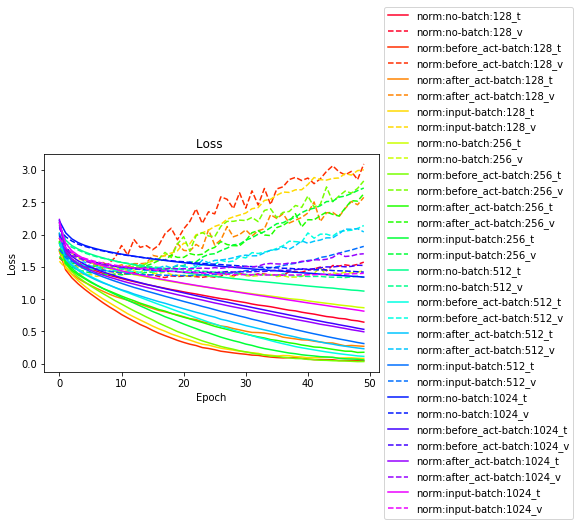

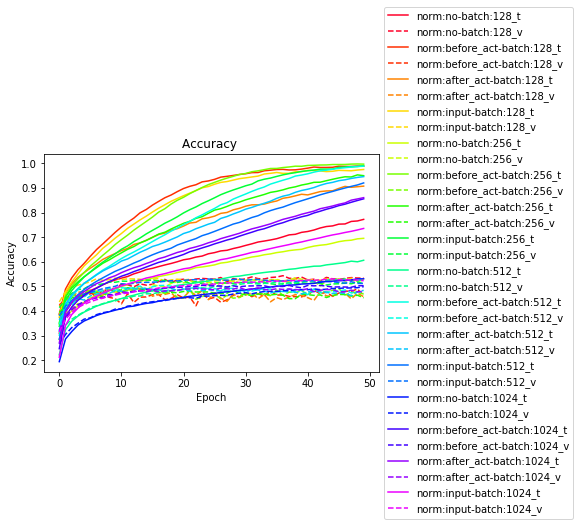

In [27]:
plot_data_2(results)

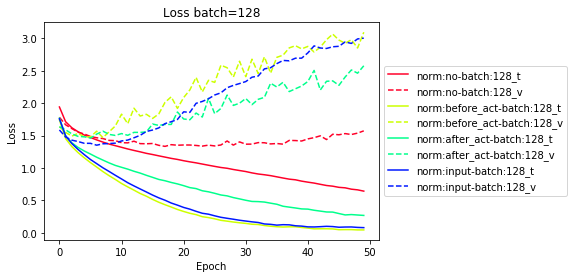

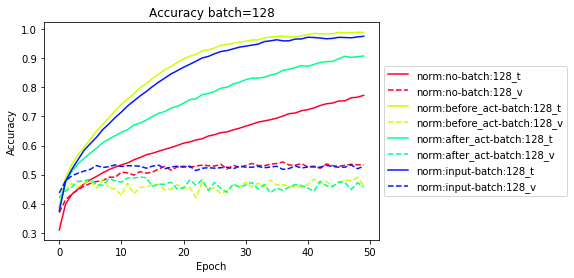

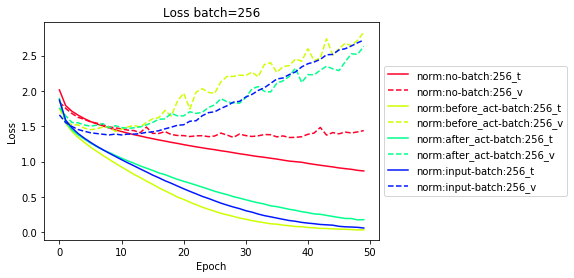

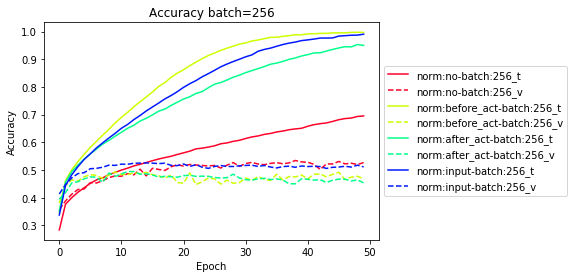

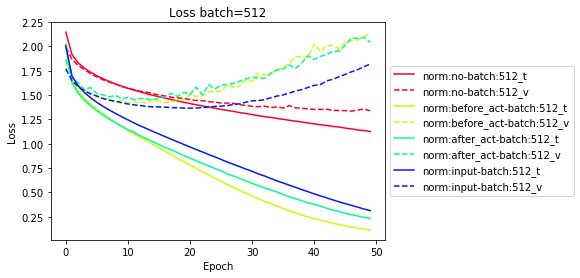

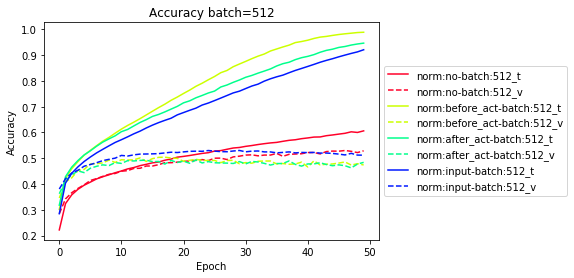

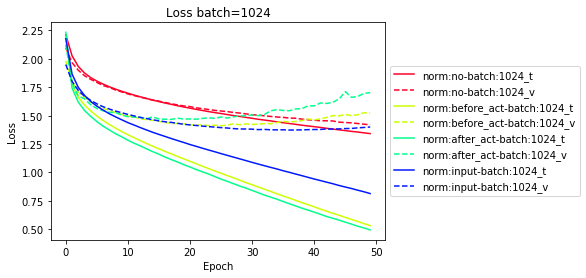

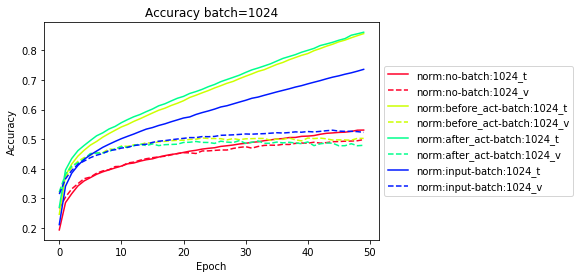

In [28]:
for batch_size in batch_size_list:
    results_by_key = {k: v for k, v in results.items() if f'{KEY_PREFIX_BATCH_SIZE}:{batch_size}' in k}
    plot_data_2(results_by_key, title=f'{KEY_PREFIX_BATCH_SIZE}={batch_size}')

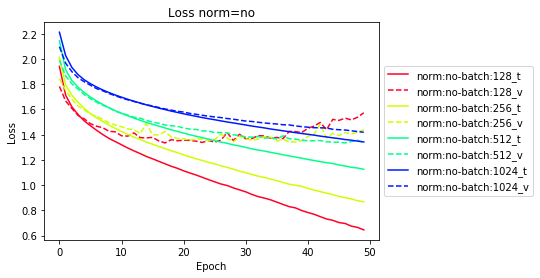

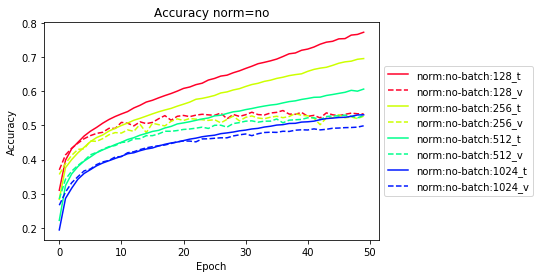

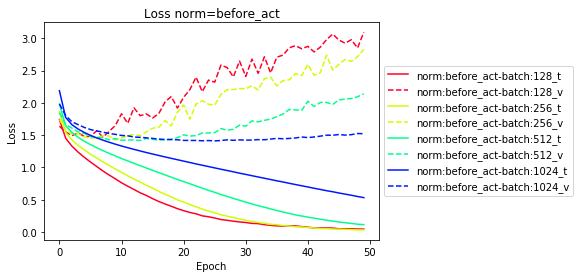

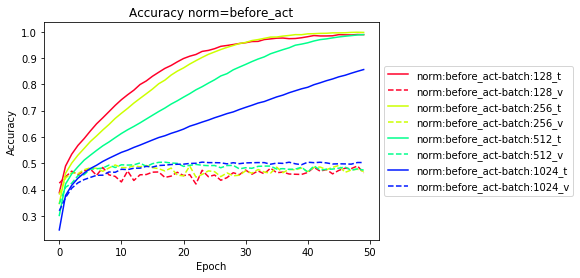

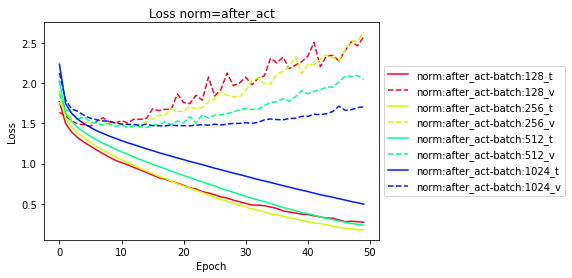

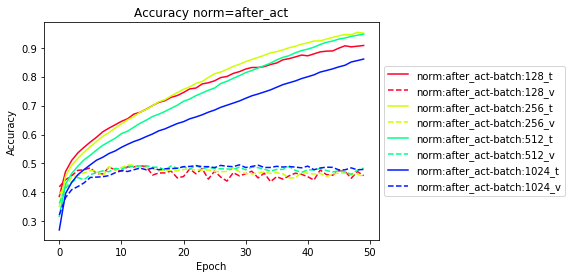

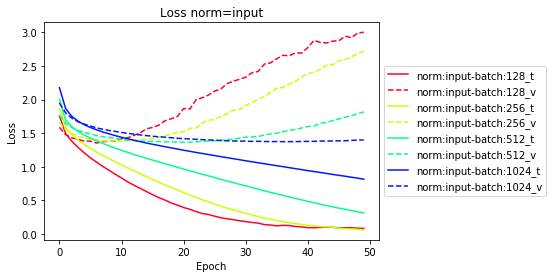

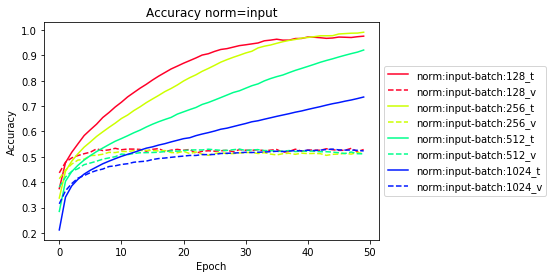

In [29]:
for norm_type in norm_type_list:
    results_by_key = {k: v for k, v in results.items() if f'{KEY_PREFIX_NORM_TYPE}:{norm_type}' in k}
    plot_data_2(results_by_key, title=f'{KEY_PREFIX_NORM_TYPE}={norm_type}')